## 강원도 신재생에너지 개발 현황 데이터 분석
이 프로젝트는 강원도 내 신재생에너지 발전 설비 현황, 발전 성과,
정책 지원, 기상 요인을 종합하여 지역별 개발 특성과
향후 개발 가능성을 분석하는 것을 목표로 한다.

### 분석 흐름
1. 발전 설비 현황 수집
2. 발전량 데이터 결합
3. 정책·지원 사업 반영
4. 기상 요인 영향 분석

In [19]:
print(energy.columns)
print(energy.head())

Index(['연도', '광역지자체', '기초지자체', '신재생에너지 합계', '재생에너지 합계', '신에너지 합계',
       '신재생에너지공급비중', '태양광', '풍력', '수력', '해양', '바이오', '재생폐기물', '연료전지', 'IGCC'],
      dtype='object')
     연도 광역지자체 기초지자체  신재생에너지 합계   재생에너지 합계  신에너지 합계  신재생에너지공급비중      태양광  \
0  2021    강원   강릉시  2,088,289  2,088,224       65       35.46  131,258   
1  2021    강원   고성군    142,575    142,575        -        2.42  141,704   
2  2021    강원    기타      4,429      4,403       26        0.08    2,769   
3  2021    강원   동해시    405,359    273,611  131,748        6.88   26,993   
4  2021    강원   삼척시    280,341    280,337        3        4.76  110,382   

       풍력      수력 해양        바이오 재생폐기물     연료전지 IGCC  
0  81,395   3,230  -  1,872,341     -       65    -  
1       -     871  -          -     -        -    -  
2   1,634       -  -          -     -       26    -  
3       -  30,284  -    216,335     -  131,748    -  
4  33,271  13,449  -    123,235     -        3    -  


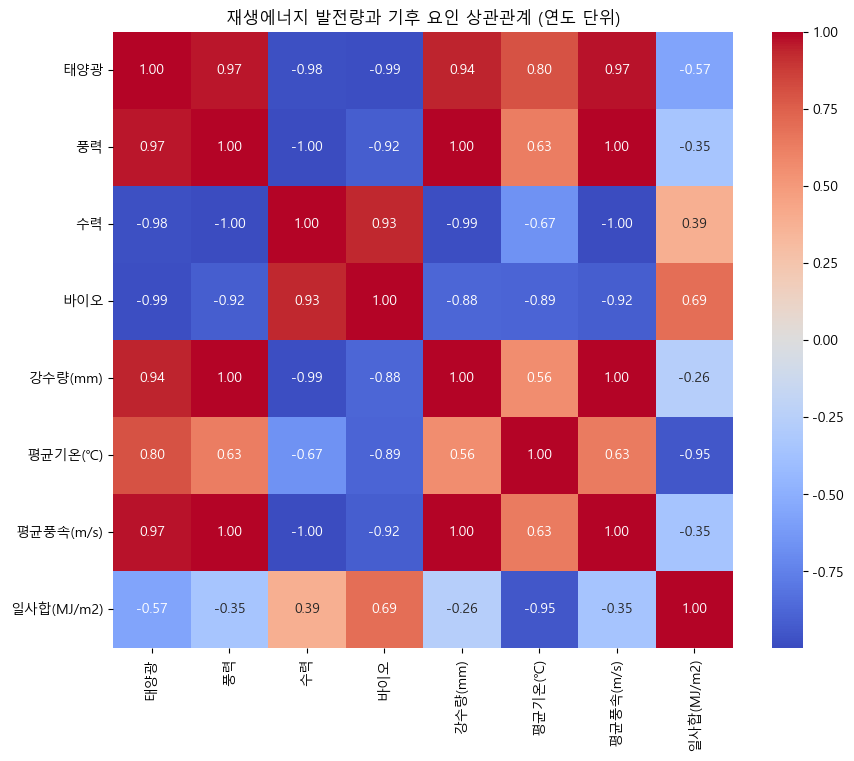

📊 상관관계 테이블:
                 태양광        풍력        수력       바이오   강수량(mm)   평균기온(℃)  \
태양광         1.000000  0.968719 -0.979398 -0.987317  0.941931  0.802585   
풍력          0.968719  1.000000 -0.998875 -0.917035  0.995800  0.629442   
수력         -0.979398 -0.998875  1.000000  0.934917 -0.990338 -0.665586   
바이오        -0.987317 -0.917035  0.934917  1.000000 -0.876673 -0.887112   
강수량(mm)     0.941931  0.995800 -0.990338 -0.876673  1.000000  0.555659   
평균기온(℃)     0.802585  0.629442 -0.665586 -0.887112  0.555659  1.000000   
평균풍속(m/s)   0.970348  0.999978 -0.999168 -0.919668  0.995169  0.634597   
일사합(MJ/m2) -0.567838 -0.345804  0.389915  0.691318 -0.258449 -0.946773   

            평균풍속(m/s)  일사합(MJ/m2)  
태양광          0.970348   -0.567838  
풍력           0.999978   -0.345804  
수력          -0.999168    0.389915  
바이오         -0.919668    0.691318  
강수량(mm)      0.995169   -0.258449  
평균기온(℃)      0.634597   -0.946773  
평균풍속(m/s)    1.000000   -0.352039  
일사합(MJ/m2)  -0.352039    1.000000

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기
energy = pd.read_excel(r"C:/Users/dkreh/Desktop/KDT_RE_5th/3_Project/01_DataAnalysis/docs/강원도_지역별_재생에너지_발전량.xlsx", sheet_name="Sheet1")
rain = pd.read_excel(r"C:/Users/dkreh/Desktop/KDT_RE_5th/3_Project/01_DataAnalysis/data/processed/강원도_월별강수량_통합.xlsx")
temp = pd.read_excel(r"C:/Users/dkreh/Desktop/KDT_RE_5th/3_Project/01_DataAnalysis/data/processed/강원도_월별기온_통합.xlsx")
wind = pd.read_excel(r"C:/Users/dkreh/Desktop/KDT_RE_5th/3_Project/01_DataAnalysis/data/processed/강원도_월별풍속_통합.xlsx")
solar = pd.read_excel(r"C:/Users/dkreh/Desktop/KDT_RE_5th/3_Project/01_DataAnalysis/data/processed/강원도_월일조일사_통합.xlsx")

# 2. 기후 데이터 전처리: '일시' → 연도, 월
for df in [rain, temp, wind, solar]:
    df["연도"] = pd.to_datetime(df["일시"]).dt.year
    df["월"] = pd.to_datetime(df["일시"]).dt.month

rain = rain[["지점명","연도","월","강수량(mm)"]]
temp = temp[["지점명","연도","월","평균기온(℃)"]]
wind = wind[["지점명","연도","월","평균풍속(m/s)"]]
solar = solar[["지점명","연도","월","일사합(MJ/m2)"]]

climate = rain.merge(temp, on=["지점명","연도","월"], how="inner") \
              .merge(wind, on=["지점명","연도","월"], how="inner") \
              .merge(solar, on=["지점명","연도","월"], how="inner")

# 3. 기후 데이터를 연도 단위로 집계
climate_yearly = climate.groupby(["지점명","연도"]).mean().reset_index()

# 4. 지역 매핑
region_map = {
    "강릉": "강릉시", "북강릉": "강릉시",
    "속초": "속초시", "원주": "원주시",
    "영월": "영월군", "인제": "인제군",
    "동해": "동해시", "대관령": "평창군",
    "북춘천": "춘천시"
}
climate_yearly["기초지자체"] = climate_yearly["지점명"].map(region_map)

# 5. 발전량 데이터 숫자형 변환 (쉼표 제거, '-' → NaN)
for col in ["태양광","풍력","수력","바이오"]:
    energy[col] = energy[col].replace("-", None)   # '-'를 NaN으로 처리
    energy[col] = energy[col].astype(str).str.replace(",", "")  # 쉼표 제거
    energy[col] = pd.to_numeric(energy[col], errors="coerce")

# 6. 병합
merged = pd.merge(energy, climate_yearly, on=["기초지자체","연도"], how="inner")

# 7. 상관관계 분석
corr = merged[["태양광","풍력","수력","바이오",
               "강수량(mm)","평균기온(℃)","평균풍속(m/s)","일사합(MJ/m2)"]].corr()

# 8. 시각화 + 테이블 출력
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("재생에너지 발전량과 기후 요인 상관관계 (연도 단위)")
plt.show()

print("📊 상관관계 테이블:")
print(corr)

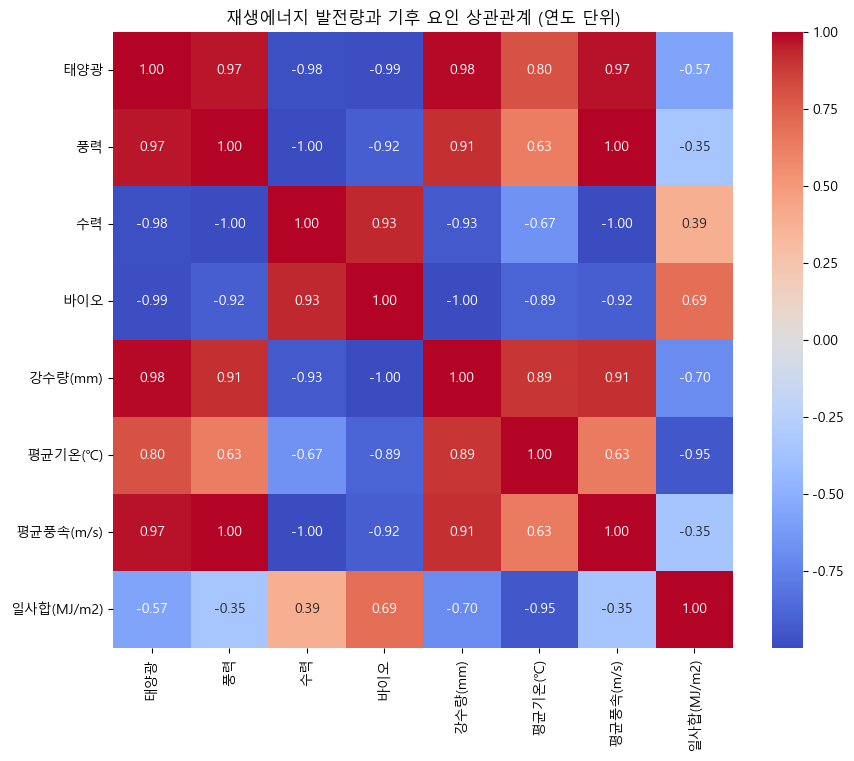

📊 상관관계 테이블:
                 태양광        풍력        수력       바이오   강수량(mm)   평균기온(℃)  \
태양광         1.000000  0.968719 -0.979398 -0.987317  0.984944  0.802585   
풍력          0.968719  1.000000 -0.998875 -0.917035  0.911233  0.629442   
수력         -0.979398 -0.998875  1.000000  0.934917 -0.929742 -0.665586   
바이오        -0.987317 -0.917035  0.934917  1.000000 -0.999898 -0.887112   
강수량(mm)     0.984944  0.911233 -0.929742 -0.999898  1.000000  0.893627   
평균기온(℃)     0.802585  0.629442 -0.665586 -0.887112  0.893627  1.000000   
평균풍속(m/s)   0.970348  0.999978 -0.999168 -0.919668  0.913953  0.634597   
일사합(MJ/m2) -0.567838 -0.345804  0.389915  0.691318 -0.701588 -0.946773   

            평균풍속(m/s)  일사합(MJ/m2)  
태양광          0.970348   -0.567838  
풍력           0.999978   -0.345804  
수력          -0.999168    0.389915  
바이오         -0.919668    0.691318  
강수량(mm)      0.913953   -0.701588  
평균기온(℃)      0.634597   -0.946773  
평균풍속(m/s)    1.000000   -0.352039  
일사합(MJ/m2)  -0.352039    1.000000

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기
energy = pd.read_excel(r"C:/Users/dkreh/Desktop/KDT_RE_5th/3_Project/01_DataAnalysis/docs/강원도_지역별_재생에너지_발전량.xlsx", sheet_name="Sheet1")
rain = pd.read_excel(r"C:/Users/dkreh/Desktop/KDT_RE_5th/3_Project/01_DataAnalysis/data/processed/강원도_월별강수량_통합.xlsx")
temp = pd.read_excel(r"C:/Users/dkreh/Desktop/KDT_RE_5th/3_Project/01_DataAnalysis/data/processed/강원도_월별기온_통합.xlsx")
wind = pd.read_excel(r"C:/Users/dkreh/Desktop/KDT_RE_5th/3_Project/01_DataAnalysis/data/processed/강원도_월별풍속_통합.xlsx")
solar = pd.read_excel(r"C:/Users/dkreh/Desktop/KDT_RE_5th/3_Project/01_DataAnalysis/data/processed/강원도_월일조일사_통합.xlsx")

# 2. 기후 데이터 전처리: '일시' → 연도, 월
for df in [rain, temp, wind, solar]:
    df["연도"] = pd.to_datetime(df["일시"]).dt.year
    df["월"] = pd.to_datetime(df["일시"]).dt.month

rain = rain[["지점명","연도","월","강수량(mm)"]]
temp = temp[["지점명","연도","월","평균기온(℃)"]]
wind = wind[["지점명","연도","월","평균풍속(m/s)"]]
solar = solar[["지점명","연도","월","일사합(MJ/m2)"]]

# 3. 네 가지 기후 데이터 합치기
climate = rain.merge(temp, on=["지점명","연도","월"], how="inner") \
              .merge(wind, on=["지점명","연도","월"], how="inner") \
              .merge(solar, on=["지점명","연도","월"], how="inner")

# 4. 연도 단위 집계
climate_yearly = climate.groupby(["지점명","연도"]).agg({
    "강수량(mm)":"sum",        # 합계
    "일사합(MJ/m2)":"sum",     # 합계
    "평균기온(℃)":"mean",      # 평균
    "평균풍속(m/s)":"mean"     # 평균
}).reset_index()

# 5. 지역 매핑
region_map = {
    "강릉": "강릉시", "북강릉": "강릉시",
    "속초": "속초시", "원주": "원주시",
    "영월": "영월군", "인제": "인제군",
    "동해": "동해시", "대관령": "평창군",
    "북춘천": "춘천시"
}
climate_yearly["기초지자체"] = climate_yearly["지점명"].map(region_map)

# 6. 발전량 데이터 숫자형 변환
for col in ["태양광","풍력","수력","바이오"]:
    energy[col] = energy[col].replace("-", None)
    energy[col] = energy[col].astype(str).str.replace(",", "")
    energy[col] = pd.to_numeric(energy[col], errors="coerce")

# 7. 병합
merged = pd.merge(energy, climate_yearly, on=["기초지자체","연도"], how="inner")

# 8. 상관관계 분석
corr = merged[["태양광","풍력","수력","바이오",
               "강수량(mm)","평균기온(℃)","평균풍속(m/s)","일사합(MJ/m2)"]].corr()

# 9. 시각화 + 테이블 출력
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("재생에너지 발전량과 기후 요인 상관관계 (연도 단위)")
plt.show()

print("📊 상관관계 테이블:")
print(corr)

# 10. 기후 데이터 엑셀로 저장 (원하시면)
climate_yearly.to_excel(r"C:/Users/dkreh/Desktop/KDT_RE_5th/3_Project/01_DataAnalysis/data/processed/climate_yearly.xlsx", index=False)